# Test model pieces

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from utils.early_stopping import EarlyStopping
import numpy as np
import copy
from tqdm import tqdm
from model.ha import HierarchicalAttPredictor
from sklearn.metrics import classification_report
# from data.evaluate import load_dev_labels, get_metrics
import pickle as pkl
import sys
from allennlp.modules.elmo import Elmo, batch_to_ids
from copy import deepcopy
import argparse
import random
from utils.focalloss import FocalLoss
from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH
# from utils.tweet_processor import processing_pipeline
import json
import pandas as pd
from nltk.tokenize import sent_tokenize
from module.preprocessor import EnglishPreProcessor
from pytorch_pretrained_bert.tokenization import BertTokenizer
from config.basic_config import configs as config
import re
import seaborn as sns

In [2]:
testnp = np.array([[1, 2], [3, 4]]) 

In [3]:
teststart = []
teststart.append(np.asarray([1, 2]))
teststart.append(np.asarray([3, 4]))

In [4]:
np.asarray(teststart).shape

(2, 2)

In [279]:
teststart = []
teststart.append([1, 2])
teststart.append([3, 4])

In [280]:
np.asarray(teststart).shape

(2, 2)

In [270]:
testnp=[[1,2],[1,2,3],[1]]

In [272]:
testnp=np.array(testnp)

In [273]:
testnp.shape

(3,)

In [2]:
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
from allennlp.modules.elmo import Elmo, batch_to_ids
elmo = Elmo(options_file, weight_file, 2, dropout=0).cuda()
elmo.eval()

100%|██████████| 374434792/374434792 [00:06<00:00, 59699433.11B/s]


Elmo(
  (_elmo_lstm): _ElmoBiLm(
    (_token_embedder): _ElmoCharacterEncoder(
      (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
      (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
      (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
      (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
      (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
      (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
      (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
      (_highways): Highway(
        (_layers): ModuleList(
          (0): Linear(in_features=2048, out_features=4096, bias=True)
          (1): Linear(in_features=2048, out_features=4096, bias=True)
        )
      )
      (_projection): Linear(in_features=2048, out_features=512, bias=True)
    )
    (_elmo_lstm): ElmoLstm(
      (forward_layer_0): LstmCellWithProjection(
        (input_linearity): Linear(in_features=512, out_features=16384, b

In [117]:
preprocessor = EnglishPreProcessor()

'123'

In [2]:
# proc pipeline not working, have to remove it
def load_data_context(data_path='/data/SuperMod/test_data.txt', is_train=True):

    data_list = []
    target_list = []
    
    df = pd.read_csv(data_path)
    
    if len(df.columns) > 4:
        data_list = df.comment_text.tolist()
        target_list = df.toxic.tolist()   

    else:
        data_list = df.comment_text.tolist()
        target_list = df.toxicity.tolist()

    clean_sent_list = [sent_tokenize(processing_pipeline(str(email))) for email in data_list]

    if is_train:
        return clean_sent_list, target_list
    else:
        return clean_sent_list
   


In [216]:
df = pd.read_csv('/data/ToxicityDataOld/train.csv')

In [224]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [130]:
preprocessor(train[4][2])

'andy          inline attachment follows          from : < email > to : zipper , andy < / o = enron / ou = na / cn = recipients / cn = azipper > date : friday , date time gmt subject : ha ha ha you stupid , arrogant fuck                                                    do you yahoo ?'

In [133]:
re.sub(r'(.+?)\1+', r'\1', 'preprocessor(train[4][2])')

'god'

In [32]:
from module import create_data

In [12]:
tokenizer = BertTokenizer(vocab_file='/root/projects/SuperMod/SentimentDetectionNLP/bertmodel/pybert/model/pretrain/uncased_L-12_H-768_A-12/vocab.txt',
                          do_lower_case=True)

In [12]:
train, label = load_data_context(data_path='/data/SuperMod/training_data_supermod.csv')

In [10]:
train_t, label_t = load_data_context(data_path='/data/ToxicityDataOld/train.csv')

In [ ]:
train_v, label_v = load_data_context(data_path='/data/ToxicityDataOld/test_with_labels.csv')

In [26]:
movie = pd.read_csv("/data/SuperMod/IMDB Dataset.csv")

In [23]:
movie.columns = ["comment_text" , "toxicity"]

In [25]:
movie.to_csv("/data/SuperMod/IMDB Dataset.csv")

In [20]:
movie["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [27]:
movie.head()

,Unnamed: 0,comment_text,toxicity
0,0,One of the other reviewers has mentioned that ...,positive
1,1,A wonderful little production. <br /><br />The...,positive
2,2,I thought this was a wonderful way to spend ti...,positive
3,3,Basically there's a family where a little boy ...,negative
4,4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [28]:
train_m, label_m = load_data_context(data_path="/data/SuperMod/IMDB Dataset.csv")

In [33]:
word2id, id2word, num_of_vocab = create_data.build_vocab([train_t, train_v, train, train_m], 20000, True)

found 24205 words
filling vocab to 20003


In [35]:
with open('/data/SuperMod/word2id.pkl', 'wb') as w:
    pkl.dump(word2id, w, pkl.HIGHEST_PROTOCOL)
with open('/data/SuperMod/id2word.pkl', 'wb') as i:
    pkl.dump(id2word, i, pkl.HIGHEST_PROTOCOL)

In [43]:
with open('/data/SuperMod/result.pkl', 'rb') as w:
    old_result = pickle.load(w)

old_result    

{0: [0.9241770608646722,
  0.5822163238221633,
  0.7203612479474548,
  0.6439633027522935],
 1: [0.9173934790084092,
  0.5460263007432818,
  0.784072249589491,
  0.6437478934951129],
 2: [0.918643908843665,
  0.5511738175089627,
  0.7825944170771757,
  0.6468073556354753],
 3: [0.9190971896589453,
  0.5530285449060107,
  0.7825944170771757,
  0.6480826760946424]}

In [29]:
df_s = pd.read_csv('/data/SuperMod/training_data_supermod.csv')
df_s.head()

,id,comment_text,toxicity
0,0,here is the latest physical tab template. row...,0
1,1,What's up in the hood? It sounds like you guy...,1
2,2,Yo Dr. Ake -\r\n\r\nI WENT AND GOT MEASURED LA...,1
3,3,this request has been pending your approval fo...,0
4,4,"Yes, Elvis is still alive and reading these pu...",1


In [37]:
train_s, label_s = load_data_context(data_path='/data/SuperMod/training_data_supermod.csv')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [166]:
if re.match(".*[a-zA-Z]+.*", '.'):
    print("yes")

In [10]:
def clean_sentences(sent_text):
    """
    This function detects if a line should be removed (all empty or no words)
    And returns a cleaned sentences without duplicated tokens
    """
    to_keep = False
    if re.match(".*[a-zA-Z]+.*", sent_text):
        to_keep = True
    remove_dup = re.sub(r'(.+?)\1+', r'\1',processing_pipeline(sent_text))
    return to_keep, remove_dup


In [199]:
def get_clean_train_data (email_text):
    
    tmp = []

    for sents in email_text:
        keep, sents = clean_sentences(sents)
        if keep:                
            tmp.append(tokenizer.tokenize(sents))
    return tmp

In [189]:
clean_train = [get_clean_train_data(email) for email in train]

In [227]:
clean_train_t = [get_clean_train_data(email) for email in train_t]

In [1]:
clean_train_t[:3]

NameError: name 'clean_train_t' is not defined

In [188]:
sent_len = []
sent_num = []

for i in clean_train:
    sent_num.append(len(i))
#     if len(i) > 50:
#         print(i)
    for j in i:
        sent_len.append(len(j))
#         if len(j) > 50:
#             print(j)

In [232]:
sent_len_t = []
sent_num_t = []

for i in clean_train_t:
    sent_num_t.append(len(i))
#     if len(i) > 50:
#         print(i)
    for j in i:
        sent_len_t.append(len(j))
#         if len(j) > 50:
#             print(j)

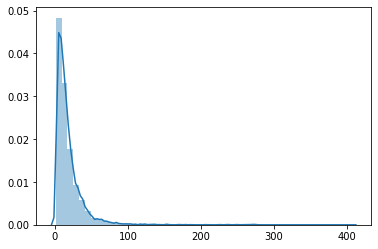

In [190]:
sns.distplot(sent_len)

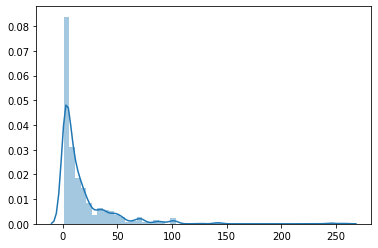

In [191]:
sns.distplot(sent_num)

In [233]:
print(np.mean(sent_num))
print(np.mean(sent_len))
print(np.mean(sent_num_t))
print(np.mean(sent_len_t))

17.916873449131515
17.765805692126584
4.768942978360729
19.15463248290045


In [234]:
print(np.median(sent_num))
print(np.median(sent_len))
print(np.median(sent_num_t))
print(np.median(sent_len_t))

9.0
12.0
3.0
15.0


In [192]:
# tokenizer.tokenize(preprocessor(train[0][0]))

In [83]:
preprocessor = EnglishPreProcessor()

In [84]:
preprocessor(raw[0])

' forwarded by dawn c kenne/hou/ect on 03/06/2001 10:38 am ---------------------------heightshappyataol.com on 03/06/2001 09:35:01 am'

In [81]:
train[0]

[' forwarded by dawn c kenne/hou/ect on 03/06/2001 10:38 am ---------------------------heightshappyataol.com on 03/06/2001 09:35:01 am']

In [ ]:
['- - - - - - - - - - - - - - - - - - - - - - forwarded by dawn c kenne / hou / ect on date time am - - - - - - - - - - - - - - - - - - - - - - - - - - - email on date time to : email , email , email , email , email , email ( laura romaine ) , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email , email .',
 'us , email , email cc : subject : things to say when you are at a loss for words .',
 'repeated number ?',
 '.',
 'repeated i can see your point , but i still think you are full of shit .',
 'number ?',
 '.',
 "repeated i do not know what your problem is , but i will bet it ' s hard to pronounce .",
 'number ?',
 '.']

In [125]:
tokenizer.tokenize(re.sub(r'(.+?)\1+', r'\1', preprocessor(train[0][0])))

['forward',
 '##ed',
 'by',
 'dawn',
 'c',
 'ken',
 '##e',
 '/',
 'ho',
 '##u',
 '/',
 'ec',
 '##t',
 'on',
 'date',
 'time',
 'am',
 'email',
 'on',
 'date',
 'time',
 'to',
 ':',
 'email',
 ',',
 'email',
 '(',
 'laura',
 'roma',
 '##ine',
 ')',
 ',',
 'email',
 '.']

In [45]:
EMAI_PAD_LEN = 3
EMOJ_SENT_PAD_LEN = SENT_PAD_LEN = 10
SENT_EMB_DIM = 300

NUM_OF_FOLD = 9
learning_rate = 5e-4
MAX_EPOCH = 2

FILL_VOCAB = True
BATCH_SIZE = 128

SENT_HIDDEN_SIZE = 1500
CLIP = 0.888
EARLY_STOP_PATIENCE = 1
LAMBDA1 = 0
LAMBDA2 = 0
FLAT = 1
VOCAB_SIZE = 100

gamma = 0.2
loss = 'ce'
w = 1
focal = 2

In [5]:
def build_vocab(clean_sent_lists, vocab_size, fill_vocab=False):
    """
    get all the words from the list, and sort them by count
    Then convert them into ids.
    This is simply word split, can improve with other tokenizer
    clean_sent_lists is a list of list of tokenized emails
    """
    word_count = {}
    word2id = {}
    id2word = {}
    
    data_list_list = []
    
    for data_list in clean_sent_lists:
        data_list_list.extend(data_list)
    
    for emails in data_list_list:
        for sentence in emails:
            keep, sents = clean_sentences(sentence)
            if keep:
                for word in tokenizer.tokenize(sents):
                    if word in word_count:
                        word_count[word] += 1
                    else:
                        word_count[word] = 1 

    word_list = [x for x, _ in sorted(word_count.items(), key=lambda v: v[1], reverse=True)]
    print('found', len(word_count), 'words')

    if len(word_count) < vocab_size:
        raise Exception('Vocab less than requested!!!')

    # add <pad> first
    word2id['<pad>'] = 0
    id2word[0] = '<pad>'

    word2id['<unk>'] = 1
    id2word[1] = '<unk>'
    word2id['<empty>'] = 2
    id2word[2] = '<empty>'

    n = len(word2id)
    if not fill_vocab:
        word_list = word_list[:vocab_size - n]

    for word in word_list:
        word2id[word] = n
        id2word[n] = word
        n += 1

    if fill_vocab:
        print('filling vocab to', len(id2word))
        return word2id, id2word, len(id2word)
    return word2id, id2word, len(word2id)



In [8]:
# word2id, id2word, length = build_vocab([train], 10000)

In [21]:
from module import create_data

Tokenizing using dictionary from /data/torchMoji/model/vocabulary.json


## build vocab for all

In [41]:
##Buid vocab to be saved to file
word2id, id2word, num_of_vocab = build_vocab([train_t, train_v, train_s], 5000, True)


found 24057 words
filling vocab to 24060


In [42]:
with open('/data/SuperMod/word2id.pkl', 'wb') as w:
    pickle.dump(word2id, w, pickle.HIGHEST_PROTOCOL)
with open('/data/SuperMod/id2word.pkl', 'wb') as i:
    pickle.dump(id2word, i, pickle.HIGHEST_PROTOCOL)
    
# with open('/data/SuperMod/my_file.pkl', 'rb') as f:
#     x = pickle.load(f)

In [9]:
# length

In [204]:
class TrainDataSet(Dataset):
    def __init__(self, data_list, target_list, emai_pad_len, sent_pad_len, word2id,  use_unk=False):

        self.sent_pad_len = sent_pad_len
        self.emai_pad_len = emai_pad_len
        self.word2id = word2id
        self.pad_int = word2id['<pad>']

        self.use_unk = use_unk

        # internal data
        # only have one input, not 3
        self.a = []
        self.a_len = []
        self.emoji_a = []
        
        # e_c is the label of emotions
        # for our project, the label is already 0, 1
        # so remove binary and label translation
        self.e_c = []
#         self.e_c_binary = []
#         self.e_c_emo = []
        self.num_empty_lines = 0

        self.weights = []
        # prepare dataset
        self.read_data(data_list, target_list)
        
    def sent_to_ids(self, sent_text):
        """
        convert words into ids, 
        this takes in sentences, not emails
        Then tokenize and convert to ids for each sentence
        """        
        tokens = tokenizer.tokenize(sent_text)
        
        if self.use_unk:
            tmp = [self.word2id[x] if x in self.word2id else self.word2id['<unk>'] for x in tokens]
        else:
            tmp = [self.word2id[x] for x in tokens if x in self.word2id]
        if len(tmp) == 0:
            tmp = [self.word2id['<empty>']]
            self.num_empty_lines += 1

        # PADDING
        if len(tmp) > self.sent_pad_len:
            tmp = tmp[: self.sent_pad_len]
        text_len = max(len(tmp), 1)

        tmp = tmp + [self.pad_int] * (self.sent_pad_len - len(tmp))
        # no need to pad emoji
        a_emoji = emoji_st.tokenize_sentences([sent_text])[0].reshape((-1)).astype(np.int64)

        return tmp, text_len, a_emoji            

    def email_to_ids(self, email_text):
        """
        convert words into ids, 
        first split email into list of sentences, then use sent_to_ids
        Then tokenize and convert to ids for each sentence
        """ 
        tmp = []
        tmp_len = []
        a_emoji = []
        
        for sents in email_text:
            keep, sents = clean_sentences(sents)
            if keep:                
                a, a_len, emoji_sent = self.sent_to_ids(sents)
                tmp.append(a)
                tmp_len.append(a_len)
                a_emoji.append(emoji_sent)
            
        if len(email_text) > self.emai_pad_len:
            tmp = tmp[: self.emai_pad_len]
            tmp_len = tmp_len[: self.emai_pad_len]
            a_emoji = a_emoji[: self.emai_pad_len]
        
        fill_times = self.emai_pad_len - len(tmp)          
        # have to make sure the fillers look accurate for it to work
        tmp = tmp +  [[self.pad_int] * self.sent_pad_len for i in range(fill_times)]      
        tmp_len = tmp_len + [1] *  fill_times    
        a_emoji = a_emoji + [[self.pad_int]  * EMOJ_SENT_PAD_LEN for i in range(fill_times)]  
 
        return tmp, tmp_len, a_emoji

    def read_data(self, data_list, target_list):
        """
        data_list: contains both cleaned and raw data
        """
        assert len(data_list) == len(target_list)

        for X, y in zip(data_list, target_list):
            
            # convert clean sentence to ids
            a, a_len, a_emoji = self.email_to_ids(X)

            self.a.append(a)
            self.a_len.append(a_len)            
            self.emoji_a.append(a_emoji)

            # append the target
            self.e_c.append(int(y)) 
    
    def __len__(self):
        return len(self.a)

    def __getitem__(self, idx):
        return  torch.LongTensor(self.a[idx]), \
            torch.LongTensor(self.a_len[idx]),\
            torch.LongTensor(self.emoji_a[idx]),\
            torch.LongTensor([self.e_c[idx]])

In [205]:
class TestDataSet(Dataset):
    """
    Process test dataset, the difference is this does not read labels
    """
    
    def __init__(self, data_list,  emai_pad_len, sent_pad_len,  word2id, id2word, use_unk=False):

        self.sent_pad_len = sent_pad_len
        self.emai_pad_len = emai_pad_len
        self.word2id = word2id
        self.pad_int = word2id['<pad>']

        self.use_unk = use_unk

        # internal data
        self.a = []
        self.a_len = []
        self.emoji_a = []


        self.num_empty_lines = 0
        # prepare dataset
        self.ex_word2id = copy.deepcopy(word2id)
        self.ex_id2word = copy.deepcopy(id2word)
        self.unk_words_idx = set()
        self.read_data(data_list)
   
        
    def sent_to_ids(self, sent_text):
        """
        convert words into ids, 
        this takes in sentences, not emails
        Then tokenize and convert to ids for each sentence
        """        
        tokens = tokenizer.tokenize(sent_text)
        
        
        if self.use_unk:
            tmp = [self.word2id[x] if x in self.word2id else self.word2id['<unk>'] for x in tokens]
        else:
            tmp = [self.word2id[x] for x in tokens if x in self.word2id]
        if len(tmp) == 0:
            tmp = [self.word2id['<empty>']]
            self.num_empty_lines += 1

        # PADDING
        if len(tmp) > self.sent_pad_len:
            tmp = tmp[: self.sent_pad_len]
        text_len = max(len(tmp),1)

        tmp = tmp + [self.pad_int] * (self.sent_pad_len - len(tmp))
        # no need to pad emoji
        a_emoji = emoji_st.tokenize_sentences([sent_text])[0].reshape((-1)).astype(np.int64)

        return tmp, text_len, a_emoji
        

    def email_to_ids(self, email_text):
        """
        convert words into ids, 
        first split email into list of sentences, then use sent_to_ids
        Then tokenize and convert to ids for each sentence
        """ 
        tmp = []
        tmp_len = []
        a_emoji = []
                
        for sents in email_text:
            keep, sents = clean_sentences(sents)
            if keep:                
                a, a_len, emoji_sent = self.sent_to_ids(sents)
                tmp.append(a)
                tmp_len.append(a_len)
                a_emoji.append(emoji_sent)
            
        if len(email_text) > self.emai_pad_len:
            tmp = tmp[: self.emai_pad_len]
            tmp_len = tmp_len[: self.emai_pad_len]
            a_emoji = a_emoji[: self.emai_pad_len]
            
            
        fill_times = self.emai_pad_len - len(tmp)    
        
        tmp = tmp +  [[self.pad_int] * self.sent_pad_len for i in range(fill_times)]      
        tmp_len = tmp_len + [1] *  fill_times    
        a_emoji = a_emoji + [[self.pad_int]  * EMOJ_SENT_PAD_LEN for i in range(fill_times)]  
 
        return tmp, tmp_len, a_emoji


    def read_data(self, data_list):
        """
        data_list: originally contains both cleaned and raw data
        since raw data not used, get rid of it
        """        
        for X in data_list:

            a, a_len, a_emoji = self.email_to_ids(X)

            self.a.append(a)
            self.a_len.append(a_len)            
            self.emoji_a.append(a_emoji)
            
        print('num of empty lines,', self.num_empty_lines)
        
    def __len__(self):
        return len(self.a) 

    def __getitem__(self, idx):
        return torch.LongTensor(self.a[idx]),\
               torch.LongTensor([self.a_len[idx]]), \
               torch.LongTensor(self.emoji_a[idx])
  

In [206]:
data_list, target_list = load_data_context(data_path='/data/SuperMod/test_data.csv')
X = data_list # read train data list
y = target_list
y = np.array(y)



with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)
emoji_st = SentenceTokenizer(vocabulary, EMOJ_SENT_PAD_LEN)

combined = list(zip(X, y))
# random.shuffle(combined)
X[:], y[:] = zip(*combined)

word2id, id2word, num_of_vocab = build_vocab([data_list], VOCAB_SIZE)

# build Glove embedding
# emb = build_embedding(id2word, GLOVE_EMB_PATH, num_of_vocab)
train_data_set = TrainDataSet(X, y, EMAI_PAD_LEN, SENT_PAD_LEN, word2id, use_unk=True)

found 8106 words


In [236]:
word2id['<pad>']

0

In [212]:

# for i, j in enumerate(train_data_set):
#     print(j[3].squeeze(0))

In [13]:
len(train_data_set)

806

In [14]:
test_data_set = TestDataSet(X, EMAI_PAD_LEN, SENT_PAD_LEN, word2id, id2word, use_unk=False)

num of empty lines, 140


In [15]:
train_data_set = TrainDataSet(X, y, EMAI_PAD_LEN, SENT_PAD_LEN, word2id, use_unk=True)

num of empty lines, 0


In [16]:
print(test_data_set.a[3])

[[41, 13, 22, 0, 0, 0, 0, 0, 0, 0], [32, 0, 0, 0, 0, 0, 0, 0, 0, 0], [27, 37, 32, 0, 0, 0, 0, 0, 0, 0]]


In [17]:
# print to test result
# for index, (a,b,c,d) in enumerate(train_data_set):
#     print(a,b,c,d)

In [18]:
def build_embedding(id2word, fname, num_of_vocab):
    """
    Build Glove Embedding, fname is the glove embedding path
    """
    import io

    def load_vectors(fname):
        print("Loading Glove Model")
        f = open(fname, 'r', encoding='utf8')
        model = {}
        #$$$$$$$$$$$$$$$$$Need to be updated$$$$$$$$$$$$$$$$$$$$$
        for line in tqdm(f.readlines(), total=2196017):
            values = line.split(' ')
            word = values[0]
            try:
                embedding = np.array(values[1:], dtype=np.float32)
                model[word] = embedding
            except ValueError:
                print(len(values), values[0])

        print("Done.", len(model), " words loaded!")
        f.close()
        return model

    def get_emb(emb_dict, vocab_size, embedding_dim):

        all_embs = np.stack(emb_dict.values())
        emb_mean, emb_std = all_embs.mean(), all_embs.std()

        emb = np.random.normal(emb_mean, emb_std, (vocab_size, embedding_dim))

        num_found = 0
        print('loading glove')
        for idx in tqdm(range(vocab_size)):
            word = id2word[idx]
            if word == '<pad>' or word == '<unk>':
                emb[idx] = np.zeros([embedding_dim])
            elif word in emb_dict:
                emb[idx] = emb_dict[word]
                num_found += 1

        return emb, num_found

    pkl_path = fname + '.pkl'
    if not os.path.isfile(pkl_path):
        print('creating pkl file for the emb text file')
        emb_dict = load_vectors(fname)
        with open(pkl_path, 'wb') as f:
            pkl.dump(emb_dict, f)
    else:
        print('loading pkl file')
        with open(pkl_path, 'rb') as f:
            emb_dict = pkl.load(f)
        print('loading finished')

    emb, num_found = get_emb(emb_dict, num_of_vocab, SENT_EMB_DIM)

    print(num_found, 'of', num_of_vocab, 'found', 'coverage', num_found/num_of_vocab)

    return emb

In [19]:
GLOVE_EMB_PATH = '/data/glove/glove.840B.300d.txt'
emb = build_embedding(id2word, GLOVE_EMB_PATH, num_of_vocab)

loading pkl file
loading finished


/root/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
100%|██████████| 100/100 [00:00<00:00, 214213.69it/s]

loading glove
97 of 100 found coverage 0.97


In [20]:
num_of_vocab = VOCAB_SIZE
train_file = '/data/SuperMod/test_data.csv'
# read data into lists
data_list, target_list = load_data_context(data_path=train_file)

# dev set
#     dev_file = 'data/dev.txt'
dev_file = '/data/SuperMod/test_data.csv'
# read data into lists    
dev_data_list, dev_target_list = load_data_context(data_path=dev_file)

# test set
#     test_file = 'data/test.txt'
test_file = '/data/SuperMod/test_data.csv'
test_data_list, test_target_list = load_data_context(data_path=test_file)

# load final test data
#     final_test_file = 'data/testwithoutlabels.txt'
final_test_file = '/data/SuperMod/test_data.csv'
final_test_data_list = load_data_context(data_path=final_test_file, is_train=False)



In [228]:
word2id, id2word, num_of_vocab = build_vocab([data_list, dev_data_list, test_data_list], num_of_vocab,
                                                 FILL_VOCAB)

found 8106 words
filling vocab to 8109


In [22]:
emb = build_embedding(id2word, GLOVE_EMB_PATH, num_of_vocab)

loading pkl file
loading finished


/root/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
100%|██████████| 10363/10363 [00:00<00:00, 290209.67it/s]

loading glove
9639 of 10363 found coverage 0.9301360609862009


In [23]:
gold_dev_data_set = TestDataSet(dev_data_list, EMAI_PAD_LEN, SENT_PAD_LEN, word2id, id2word, use_unk=False)
gold_dev_data_loader = DataLoader(gold_dev_data_set, batch_size=BATCH_SIZE, shuffle=False)
print("Size of test data", len(gold_dev_data_set))

num of empty lines, 0
Size of test data 806


In [24]:
test_data_set = TestDataSet(test_data_list, EMAI_PAD_LEN, SENT_PAD_LEN, word2id, id2word, use_unk=False)
test_data_loader = DataLoader(test_data_set, batch_size=BATCH_SIZE, shuffle=False)
print("Size of test data", len(test_data_set))
# ex_id2word, unk_words_idx = test_data_set.get_ex_id2word_unk_words()

# convert to TestData class
# then use Dataloader from torch.utils.data to create batches
final_test_data_set = TestDataSet(final_test_data_list, EMAI_PAD_LEN, SENT_PAD_LEN, word2id, id2word, use_unk=False)
final_test_data_loader = DataLoader(final_test_data_set, batch_size=BATCH_SIZE, shuffle=False)
print("Size of final test data", len(final_test_data_set))

num of empty lines, 0
Size of test data 806
num of empty lines, 0
Size of final test data 806


In [25]:
def glove_tokenizer(ids, __id2word):
    """
    This function is only called in elmo. Elmo encode is then called
    _id2word: returned by build vocab
    This simply uses id returned from vocab building function 
    """
    return [__id2word[int(x)] for x in ids if x != 0]

def elmo_encode(data, __id2word=id2word):
    """
    get the id2word from vocab, then convert to id
    from allennlp.modules.elmo import Elmo, batch_to_ids
    Elmo needs to be trained?
    """
    data_text = [glove_tokenizer(x, __id2word) for x in data]
    sent_pad_len = SENT_PAD_LEN
    
    with torch.no_grad():
        character_ids = batch_to_ids(data_text).cuda()
        elmo_emb = elmo(character_ids)['elmo_representations']
        elmo_emb = (elmo_emb[0] + elmo_emb[1]) / 2  # avg of two layers
        sent_len = elmo_emb.shape[1]
        row_num =  elmo_emb.shape[0]
        elmo_dim = elmo_emb.shape[2]
        if sent_len < sent_pad_len:
            fill_sent_len = sent_pad_len - sent_len
            filler = torch.zeros([row_num,fill_sent_len,elmo_dim], dtype=torch.float)
            elmo_emb = torch.cat((elmo_emb, filler.cuda()), dim=1)
    return elmo_emb.cuda()

In [26]:
# sent_pad_len = SENT_PAD_LEN
# data_text = [glove_tokenizer(x, id2word) for x in a[0]]
# character_ids = batch_to_ids(data_text).cuda()
# elmo_emb = elmo(character_ids)['elmo_representations']
# elmo_emb = (elmo_emb[0] + elmo_emb[1]) / 2  # avg of two layers
# sent_len = elmo_emb.shape[1]
# row_num =  elmo_emb.shape[0]
# elmo_dim = elmo_emb.shape[2]
# if sent_len < sent_pad_len:
#     fill_sent_len = sent_pad_len - sent_len
#     filler = torch.zeros([row_num,fill_sent_len,elmo_dim], dtype=torch.float)
#     elmo_emb = torch.cat((elmo_emb, filler.cuda()), dim=1)
# elmo_emb

In [27]:
X = data_list # read train data list
y = target_list
y = np.array(y)

combined = list(zip(X, y))
random.shuffle(combined)
X[:], y[:] = zip(*combined)

# train dev split
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=NUM_OF_FOLD, random_state=0)
all_fold_results = []
real_test_results = []


In [28]:
len(train_data_set)/BATCH_SIZE

6.296875

## now we look at one fold

In [29]:
num_fold = 1
train_index = []
dev_index = []

for idx, (_train_index, _dev_index) in enumerate(skf.split(X, y)):
    num_fold = idx
    train_index = _train_index[:20]
    dev_index = _dev_index[:20]
    
# train, dev indices only contain indexes
# by doing this, we grab the last fold to examine

In [30]:
 
X_train, X_dev = [X[i] for i in train_index], [X[i] for i in dev_index]
y_train, y_dev = y[train_index], y[dev_index]

# construct data loader
# for one fold, test data comes from k fold split.
train_data_set = TrainDataSet(X_train, y_train, EMAI_PAD_LEN, SENT_PAD_LEN, word2id, use_unk=True)

dev_data_set = TrainDataSet(X_dev, y_dev, EMAI_PAD_LEN, SENT_PAD_LEN, word2id, use_unk=True)
dev_data_loader = DataLoader(dev_data_set, batch_size=BATCH_SIZE, shuffle=False)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pred_list_test_best = None
final_pred_best = None


num of empty lines, 0
num of empty lines, 0


In [31]:
print out for testing
for i, j in enumerate(train_data_set):
    print(j)

In [32]:
# train_data_set[:2]

In [33]:
BATCH_SIZE = 5
train_data_loader = DataLoader(train_data_set, batch_size=BATCH_SIZE, shuffle=True)

In [34]:
for i, (a,b,c,d) in enumerate(train_data_loader) :
    last_a = a
    last_b = b
    last_c = c
    last_d = d
# again we grab the last batch

In [35]:
last_a

tensor([[[   3, 3255, 3256,   13,   57,  191,  121,   32,    0,    0],
         [   3,    3,    7,   14,  967,   34,   37,  806,  123,   32],
         [ 133,  228,   85,   84, 1943,   37,  277,    5,   14,    0]],

        [[  15, 3160, 1360, 1483,  130,   15,  528,   77,  665,    6],
         [  73, 5673,  109,   62,  140, 4609,  490,  245,    5,    0],
         [ 240,    9, 5674,    6,   79,  529, 5675,   89,   79, 3300]],

        [[  12,  142,   42, 1496,  141,   18,   39,    9, 6965, 1505],
         [  62,  134,   30,   73,   41,   15,  558,   19, 4142,    5],
         [  62,  320,  134,   62,   25,  404,   30,   28,    5,    0]],

        [[   4,    4,    4,    4,    4,    4,    4,    4,    4,    4],
         [1979, 2882,    8,   87,  804,   24,  281,   84,  717, 2883],
         [   3,    3,   18,    5,    0,    0,    0,    0,    0,    0]],

        [[ 241,    4,   13,   40,   10,  150,   48,  121,  116,   32],
         [   4,    4,    4,    4,    4,   50,   46,    4,    4,    4]

In [36]:
last_a[:,2,:]

tensor([[ 133,  228,   85,   84, 1943,   37,  277,    5,   14,    0],
        [ 240,    9, 5674,    6,   79,  529, 5675,   89,   79, 3300],
        [  62,  320,  134,   62,   25,  404,   30,   28,    5,    0],
        [   3,    3,   18,    5,    0,    0,    0,    0,    0,    0],
        [8894,  135,  285,  116,   34, 3613,    5,    0,    0,    0]])

In [37]:
last_a.shape[1]

3

In [38]:
last_a.shape[0]

5

In [39]:
last_b.shape

torch.Size([5, 3])

In [40]:
last_b

tensor([[ 8, 10,  9],
        [10,  9, 10],
        [10, 10,  9],
        [10, 10,  4],
        [10, 10,  7]])

In [41]:
for i in last_a:
    print(i)
    print("next")

tensor([[   3, 3255, 3256,   13,   57,  191,  121,   32,    0,    0],
        [   3,    3,    7,   14,  967,   34,   37,  806,  123,   32],
        [ 133,  228,   85,   84, 1943,   37,  277,    5,   14,    0]])
next
tensor([[  15, 3160, 1360, 1483,  130,   15,  528,   77,  665,    6],
        [  73, 5673,  109,   62,  140, 4609,  490,  245,    5,    0],
        [ 240,    9, 5674,    6,   79,  529, 5675,   89,   79, 3300]])
next
tensor([[  12,  142,   42, 1496,  141,   18,   39,    9, 6965, 1505],
        [  62,  134,   30,   73,   41,   15,  558,   19, 4142,    5],
        [  62,  320,  134,   62,   25,  404,   30,   28,    5,    0]])
next
tensor([[   4,    4,    4,    4,    4,    4,    4,    4,    4,    4],
        [1979, 2882,    8,   87,  804,   24,  281,   84,  717, 2883],
        [   3,    3,   18,    5,    0,    0,    0,    0,    0,    0]])
next
tensor([[ 241,    4,   13,   40,   10,  150,   48,  121,  116,   32],
        [   4,    4,    4,    4,    4,   50,   46,    4,    4,    

In [42]:
# for i, (a, a_len, emoji_a, e_c) \
#                     in tqdm(enumerate(train_data_loader), total=len(train_data_set)/BATCH_SIZE):
#     print(a)

In [47]:
model = HierarchicalAttPredictor(SENT_EMB_DIM, SENT_HIDDEN_SIZE, 100, num_of_vocab,SENT_PAD_LEN , id2word, USE_ELMO=True, ADD_LINEAR=False)

In [48]:
model.summary()

AttributeError: 'HierarchicalAttPredictor' object has no attribute 'summary'

In [ ]:
HierarchicalAttPredictor(SENT_EMB_DIM, SENT_HIDDEN_SIZE, CTX_LSTM_DIM, num_of_vocab, SENT_PAD_LEN , id2word, USE_ELMO=True, ADD_LINEAR=False) 

In [44]:
model.load_embedding(emb)
model.deepmoji_model.load_specific_weights(PRETRAINED_PATH, exclude_names=['output_layer'])
model.cuda()


Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights for output_layer.0.weight
Ignoring weights for output_layer.0.bias


HierarchicalAttPredictor(
  (deepmoji_model): TorchMoji(
    (embed): Embedding(50000, 256)
    (embed_dropout): Dropout2d(p=0.2)
    (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
    (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
    (attention_layer): AttentionOneParaPerChan(2304)
    (final_dropout): Dropout2d(p=0.2)
  )
  (deepmoji2linear): Linear(in_features=2304, out_features=300, bias=True)
  (a_lstm): LSTM(1324, 1500, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (a_self_attention): AttentionOneParaPerChan(3000)
  (context_lstm): LSTM(5304, 800, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (ctx_self_attention): AttentionOneParaPerChan(1600)
  (embeddings): Embedding(10363, 300, padding_idx=0)
  (context_to_emo): Linear(in_features=800, out_features=2, bias=True)
  (drop_out): Dropout(p=0.2)
  (out2label): Linear(in_features=1600, out_features=1, bias=True)
)

In [45]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True) #
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# if opt.w == 1:
#     weight_list = [0.3, 0.3, 0.3, 1.7]
#     weight_list_binary = [2 - weight_list[-1], weight_list[-1]]
# elif opt.w == 2:
#     weight_list = [0.3198680179, 0.246494733, 0.2484349259, 1.74527696]
#     weight_list_binary = [2 - weight_list[-1], weight_list[-1]]
# else:
#     raise ValueError

In [46]:
if w == 1:
    weight_list = [1, 1]
elif w == 2:
    weight_list = [1, 1]
else:
    raise ValueError

weight_list = [x**FLAT for x in weight_list]
weight_label = torch.Tensor(weight_list).cuda()
# weight is multiplied directly to the loss label

print('classification reweight: ', weight_list)

# loss_criterion_binary = nn.CrossEntropyLoss(weight=weight_list_binary)  #
if loss == 'focal':
    loss_criterion = FocalLoss(gamma= focal )

elif loss == 'ce':
    loss_criterion = nn.BCELoss()



es = EarlyStopping(patience=EARLY_STOP_PATIENCE)
# best_model = None
final_pred_list_test = None
pred_list_test = None




classification reweight:  [1, 1]


In [56]:
for num_epoch in range(2):
    # to ensure shuffle at ever epoch
    train_data_loader = DataLoader(train_data_set, batch_size=BATCH_SIZE, shuffle=True)

    print('Begin training epoch:', num_epoch, end='...\t')
    sys.stdout.flush()

    # stepping scheduler
    scheduler.step(num_epoch)
    print('Current learning rate', scheduler.get_lr())

    train_loss = 0
    model.train()
    
    for i, (a, a_len, emoji_a, e_c) \
            in tqdm(enumerate(train_data_loader), total=len(train_data_set)/BATCH_SIZE):
        
        e_c = e_c.type(torch.float)
        optimizer.zero_grad()
        
        pred = model(a.cuda(), a_len, emoji_a.cuda())
        print(e_c.type())
        loss_label = loss_criterion(pred, e_c.view(-1).cuda()).cuda()
        print(loss_label)
#         e_c = e_c.type(torch.LongTensor)        
#         loss_label = torch.matmul(torch.gather(weight_label, 0, e_c.view(-1).cuda()), loss_label) / \
#                      e_c.view(-1).shape[0]

    
        # training trilogy
        loss_label.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        train_loss += loss_label.data.cpu().numpy() * a.shape[0]
#         del pred, loss, elmo_a, elmo_b, elmo_c, e_c_emo, loss_binary, loss_label, loss_emo


Begin training epoch: 0...	

  0%|          | 0/4.0 [00:00<?, ?it/s]

Current learning rate [0.0005]


 25%|██▌       | 1/4.0 [00:00<00:01,  2.14it/s]

torch.FloatTensor
tensor(0.8371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 2/4.0 [00:00<00:00,  2.16it/s]

torch.FloatTensor
tensor(0.5544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 3/4.0 [00:01<00:00,  2.17it/s]

torch.FloatTensor
tensor(0.2898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|██████████| 4/4.0 [00:01<00:00,  2.19it/s]

torch.FloatTensor
tensor(0.4843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Begin training epoch: 1...	


  0%|          | 0/4.0 [00:00<?, ?it/s]

Current learning rate [2e-05]


 25%|██▌       | 1/4.0 [00:00<00:01,  2.21it/s]

torch.FloatTensor
tensor(0.7421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 50%|█████     | 2/4.0 [00:00<00:00,  2.21it/s]

torch.FloatTensor
tensor(0.3112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 75%|███████▌  | 3/4.0 [00:01<00:00,  2.22it/s]

torch.FloatTensor
tensor(0.2881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|██████████| 4/4.0 [00:01<00:00,  2.22it/s]

torch.FloatTensor
tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [238]:
pred

tensor([[0.7581],
        [0.7615],
        [0.7605],
        [0.7549],
        [0.7549]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [240]:
e_c

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.]])

In [263]:
predictions = pred
ground = np.array([1 if x == 1 else 0 for x in e_c ])
THRESHHOLD = 0.5
discretePredictions = np.array([1  for x in predictions if x >= THRESHHOLD])
truePositives = np.sum([1 for (x,y) in zip(discretePredictions, ground) if x * y == 1])
falsePositives = np.sum(np.clip(discretePredictions - ground, 0, 1), axis=0)
falseNegatives = np.sum(np.clip(ground - discretePredictions, 0, 1), axis=0)

In [265]:
falsePositives


1

In [266]:
def get_metrics(ground, predictions):
    """Given predicted labels and the respective ground truth labels, display some metrics
    Input: shape [# of samples, NUM_CLASSES]
        predictions : Model output. Every row has 4 decimal values, with the highest belonging to the predicted class
        ground : Ground truth labels, converted to one-hot encodings. A sample belonging to Happy class will be [0, 1, 0, 0]
    Output:
        accuracy : Average accuracy
        microPrecision : Precision calculated on a micro level. Ref -
        https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001
        microRecall : Recall calculated on a micro level
        microF1 : Harmonic mean of microPrecision and microRecall. Higher value implies better classification
    """
    ground = np.array([1 if x == 1 else 0 for x in ground ])
    discretePredictions = np.array([1  for x in predictions if x >= THRESHHOLD])
    truePositives = np.sum([1 for (x,y) in zip(discretePredictions, ground) if x * y == 1])
    falsePositives = np.sum(np.clip(discretePredictions - ground, 0, 1), axis=0)
    falseNegatives = np.sum(np.clip(ground - discretePredictions, 0, 1), axis=0)

    print("True Positives per class : ", truePositives)
    print("False Positives per class : ", falsePositives)
    print("False Negatives per class : ", falseNegatives)

    #  Macro level calculation

    precision = truePositives / (truePositives + falsePositives)
    recall = truePositives/ (truePositives + falseNegatives)
    accuracy = np.mean(discretePredictions == ground)
    f1 = (2 * recall * precision) / (precision + recall) if (precision + recall) > 0 else 0
    print("Accuracy : %.4f, Precision : %.3f, Recall : %.3f, F1 : %.3f" % (accuracy,  precision, recall, f1))


    return accuracy, precision, recall, f1

In [267]:
get_metrics(e_c, pred)

True Positives per class :  4
False Positives per class :  1
False Negatives per class :  0
Accuracy : 0.8000, Precision : 0.800, Recall : 1.000, F1 : 0.889


(0.8, 0.8, 1.0, 0.888888888888889)

## Now test the actual model
## Start
HierarchicalPredictor(SENT_EMB_DIM, SENT_HIDDEN_SIZE, num_of_vocab, USE_ELMO=True, ADD_LINEAR=False)

    def __init__(self, embedding_dim, hidden_dim, vocab_size, USE_ELMO, ADD_LINEAR):

last_a = a  
last_b = b  
last_c = c   
last_d = d  


for i, (a, a_len, emoji_a, e_c) \
                in tqdm(enumerate(train_data_loader), total=len(train_data_set)/BATCH_SIZE):
            optimizer.zero_grad()
            elmo_a = elmo_encode(a)

            pred = model(a.cuda(), a_len, emoji_a.cuda(), elmo_a)

            # compare predicted with the actual label
            loss_label = loss_criterion(pred, e_c.view(-1).cuda()).cuda()
            # The torch.gather function is a multi-index selection method
            loss_label = torch.matmul(torch.gather(weight_label, 0, e_c.view(-1).cuda()), loss_label) / \
                         e_c.view(-1).shape[0]

            # weighting the different losses. For email, just use the label
            loss = loss_label 

            # loss = torch.matmul(torch.gather(weight, 0, trg.view(-1).cuda()), loss) / trg.view(-1).shape[0]

            # training trilogy
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()

            train_loss += loss.data.cpu().numpy() * a.shape[0]
            del pred, loss, elmo_a, loss_label


In [ ]:
# ########
# ####### After testing, do not run the following
# import numpy as np
# import torch.nn as nn
# import torch.nn.functional as F
# import torch
# from torch.autograd import Variable
# from module.self_attention import BertAttention, AttentionOneParaPerChan
# from module.torch_moji import TorchMoji

# import pickle as pkl
# import os
# from tqdm import tqdm

# embedding_dim = SENT_EMB_DIM
# hidden_dim = SENT_HIDDEN_SIZE
# SENT_LSTM_DIM = SENT_HIDDEN_SIZE
# bidirectional = True
# add_linear = True

# sent_lstm_directions = 2 if bidirectional else 1
# # centence level lstm attention
# cent_lstm_att_fn = AttentionOneParaPerChan
# # context lstm attention
# ctx_lstm__att_fn = AttentionOneParaPerChan

# NUM_EMO = 2


# deepmoji_model = TorchMoji(nb_classes=None,
#                                 nb_tokens=50000,
#                                 embed_dropout_rate=0.2,
#                                 final_dropout_rate=0.2)
# deepmoji_dim = 2304
# deepmoji_out = 300
# deepmoji2linear = nn.Linear(deepmoji_dim, deepmoji_out)

# elmo_dim = 1024

# num_layers = 2
# use_elmo = True


In [ ]:
# # ########
# # ####### After testing, do not run the following
# a_lstm = nn.LSTM(embedding_dim + elmo_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=0.2) 
# a_self_attention = cent_lstm_att_fn(sent_lstm_directions*hidden_dim)
# ctx_bidirectional = True
# ctx_lstm_dim = 800
# ctx_lstm_directions = 2 if ctx_bidirectional else 1

# if not add_linear:
#     deepmoji_out = deepmoji_dim

# context_lstm = nn.LSTM(SENT_LSTM_DIM * sent_lstm_directions + deepmoji_out, ctx_lstm_dim,
#                                     num_layers=2, batch_first=True, dropout=0.2, bidirectional=ctx_bidirectional)
# ctx_self_attention = ctx_lstm__att_fn(ctx_lstm_directions * ctx_lstm_dim)

# vocab_size = num_of_vocab
# embedding_dim = embedding_dim
# embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)




# # create a linear model that goes from context lstm dim to prediction
# context_to_emo = nn.Linear(ctx_lstm_dim, 2)
# drop_out = nn.Dropout(0.2)
# out2label = nn.Linear(ctx_lstm_dim * ctx_lstm_directions, 1)

# embeddings.cuda()
# context_lstm.cuda()
# a_lstm.cuda()
# # deepmoji_model.cuda()
# # a_self_attention.cuda()
# deepmoji2linear.cuda()
# out2label.cuda()




In [ ]:
# # # ########
# # # ####### After testing, do not run the following

# def init_hidden( x):
#     batch_size = x.size(0)
#     if bidirectional:
#         h0 = Variable(torch.zeros(2*num_layers, batch_size, SENT_LSTM_DIM), requires_grad=False).cuda()
#         c0 = Variable(torch.zeros(2*num_layers, batch_size, SENT_LSTM_DIM), requires_grad=False).cuda()
#     else:
#         h0 = Variable(torch.zeros(1*num_layers, batch_size, SENT_LSTM_DIM), requires_grad=False).cuda()
#         c0 = Variable(torch.zeros(1*num_layers, batch_size, SENT_LSTM_DIM), requires_grad=False).cuda()
#     return (h0, c0)

# def sort_batch(batch, lengths):
#     seq_lengths, perm_idx = lengths.sort(0, descending=True)
#     seq_tensor = batch[perm_idx]
#     rever_sort = np.zeros(len(seq_lengths))
#     for i, l in enumerate(perm_idx):
#         rever_sort[l] = i
#     return seq_tensor, seq_lengths, rever_sort.astype(int), perm_idx

# def sent_lstm_forward( x, x_len, lstm, hidden=None, attention_layer=None):
#     x, x_len_sorted, reverse_idx, perm_idx = sort_batch(x, x_len.view(-1))
#     max_len = int(x_len_sorted[0])
#     """
#     this only contains the sentence level LSTM
#     a_out, a_hidden = self.lstm_forward(a, a_len, elmo_a, self.a_lstm,
#                                 attention_layer=self.a_self_attention)
#     """

#     emb_x = embeddings(x)
#     emb_x = drop_out(emb_x)
# #     emb_x = emb_x[:, :max_len, :]

#     if use_elmo:
#         #concatnate elmo and Glove
#         elmo_x = elmo_encode(x)        
#         elmo_x = elmo_x[perm_idx]
#         elmo_x = drop_out(elmo_x)
#         emb_x = torch.cat((emb_x.cuda(), elmo_x), dim=2)

#     packed_input = nn.utils.rnn.pack_padded_sequence(emb_x, x_len_sorted.cpu().numpy(), batch_first=True)
#     if hidden is None:
#         hidden = init_hidden(x)

#     packed_output, hidden = lstm(packed_input, hidden)
#     output, unpacked_len = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

#     # attention_layer = None  # testing
#     if attention_layer is None:
#         seq_len = torch.LongTensor(unpacked_len).view(-1, 1, 1).expand(output.size(0), 1, output.size(2))
#         seq_len = Variable(seq_len - 1).cuda()
#         output = torch.gather(output, 1, seq_len).squeeze(1)
#     else:
#         if isinstance(attention_layer, AttentionOneParaPerChan):
#             output, alpha = attention_layer(output, unpacked_len)
#         else:
#             unpacked_len = [int(x.data) for x in unpacked_len]
#             # print(unpacked_len)
#             max_len = max(unpacked_len)
#             mask = [[1] * l + [0] * (max_len - l) for l in unpacked_len]
#             mask = torch.FloatTensor(np.asarray(mask)).cuda()
#             attention_mask = torch.ones_like(mask)
#             extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
#             # extended_attention_mask = extended_attention_mask.to(
#             #       type=next(self.parameters()).dtype)  # fp16 compatibility
#             extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
#             output, alpha = attention_layer(output, extended_attention_mask)
#             # out, att = self.attention_layer(lstm_out[:, -1:].squeeze(1), lstm_out)
#             output = output[:, 0, :]

#     return output[reverse_idx], (hidden[0][:, reverse_idx, :], hidden[1][:, reverse_idx, :])

# def load_embedding( emb):
#     embeddings.weight = nn.Parameter(torch.FloatTensor(emb))


In [ ]:

# # ########
# # ####### After testing, do not run the following

# a.shape
# a = last_a
# a_len = last_b 
# emoji_a = last_c 
# e_c = last_d

### Have to move elmo_encode into the model, because takes in batches

In [ ]:

# elmo_a = torch.stack([elmo_encode(email) for email in a])
# data_text = [glove_tokenizer(x, id2word) for x in a[0]]

In [ ]:
# # # # ########
# # # # ####### After testing, do not run the following

# context_in = []
# list_of_a = a
# list_of_a_len = a_len
# list_of_a_emoji = emoji_a

# for i in range(EMAI_PAD_LEN):
#     """
#     list_of_a: list of list of words
#     list_of_a_len: list of list of lengths 
#     a: correspond to an email
#     a_len: correspond to sentence lengths in an email
#     """
#     a = list_of_a[:,i,:]
#     a_len = list_of_a_len[:,i]
#     a_emoji = list_of_a_emoji[:,i,:]

    
#     print(a.shape)
#     print("-------------------a ----------", a.device)
#     print(a_len.shape)
#     print("-------------------a_len ----------",a_len.device)    
#     print(a_emoji.shape)
#     print("-------------------a_emoji ----------", a_emoji.device)    

#     # elmo_a: whether to use elmo in this model
#     # this lstm does not have emoji

#     a_out, a_hidden = sent_lstm_forward(a.cuda(), a_len, a_lstm,
#                                         attention_layer=a_self_attention)
    
#     print(a_out)
#     print("-------------------a_out ----------", a_out.shape)
    
#     # a_out = a_out[:, 0, :]
#     if add_linear:
#         a_emoji = deepmoji_model(a_emoji.cuda())
#         a_emoji = deepmoji2linear(a_emoji)
#         a_emoji = F.relu(a_emoji)
#         a_emoji = drop_out(a_emoji)
#     else:
#         a_emoji = deepmoji_model(a_emoji)
#         a_emoji = F.relu(a_emoji)

#     # a_out = torch.cat((F.relu(a_out), a_emoji), dim=1)
#     a_out = torch.cat((a_out, a_emoji), dim=1)

#     context_in.append(a_out.unsqueeze(1))

# # Context LSTM
# context_in = torch.cat(context_in, dim=1).cuda()

In [74]:
# # # # # ########
# # # # # ####### After testing, do not run the following

# a_out.shape
# for i in a_hidden:
#     print(i.shape)
# context_in.shape    
# ctx_out, _ = context_lstm(context_in)
# ctx_out.shape

# NUM_OF_ROWS = list_of_a.shape[0]
# ctx_self_attention.cuda()
# if isinstance(ctx_self_attention, AttentionOneParaPerChan):
#     ctx_out, _ = ctx_self_attention(ctx_out, torch.LongTensor([EMAI_PAD_LEN for _ in range(NUM_OF_ROWS)]))
# else:
#     ctx_out, _ = ctx_self_attention(ctx_out)
#     ctx_out = ctx_out[:, 0, :]  
    
# ctx_out.shape    
# torch.sigmoid(out2label(ctx_out))    

torch.Size([4, 5, 1500])
torch.Size([4, 5, 1500])


## Now test the actual model
## End

In [ ]:
     for i, (a, a_len, emoji_a, e_c) \
                        in tqdm(enumerate(train_data_loader), total=len(train_data_set)/BATCH_SIZE):
                    optimizer.zero_grad()
                    elmo_a = elmo_encode(a)

                    pred = model(a.cuda(), a_len, emoji_a.cuda(), elmo_a)
                    
                    # compare predicted with the actual label
                    loss_label = loss_criterion(pred, e_c.view(-1).cuda()).cuda()
                    # The torch.gather function is a multi-index selection method
                    loss_label = torch.matmul(torch.gather(weight_label, 0, e_c.view(-1).cuda()), loss_label) / \
                                 e_c.view(-1).shape[0]

                    # weighting the different losses. For email, just use the label
                    loss = loss_label 

                    # loss = torch.matmul(torch.gather(weight, 0, trg.view(-1).cuda()), loss) / trg.view(-1).shape[0]

                    # training trilogy
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
                    optimizer.step()

                    train_loss += loss.data.cpu().numpy() * a.shape[0]
                    del pred, loss, elmo_a, loss_label


In [82]:




def forward( list_of_a, list_of_a_len, list_of_a_emoji,  elmo_a=None):        
    """
    This forward the model on the email level, not sentence level
    (a, a_len, emoji_a, e_c) in enumerate(dev_data_loader)
    """


    # it represents the number of sentences we have padded/cut off for each email
    # we have to append results for each sentence together for the email-wide attention
    EMAI_PAD_LEN = list_of_a.shape[1]
    NUM_OF_ROWS = list_of_a.shape[0]

    # going to concat all the output into one to be put into contex lstm
    context_in = []

    for i in range(EMAI_PAD_LEN):
        """
        list_of_a: list of list of words
        list_of_a_len: list of list of lengths 
        a: correspond to an email
        a_len: correspond to sentence lengths in an email
        """
        a = list_of_a[:,i,:]
        a_len = list_of_a_len[:,i]
        a_emoji = list_of_a_emoji[:,i,:]

        # USE_elmo: whether to use elmo in this model
        # this lstm does not have emoji
        a_out, a_hidden = self.sent_lstm_forward(a, a_len, elmo_a, self.a_lstm,
                                            attention_layer=self.a_self_attention)

        # a_out = a_out[:, 0, :]
        if self.add_linear:
            a_emoji = self.deepmoji_model(a_emoji)
            a_emoji = self.deepmoji2linear(a_emoji)
            a_emoji = F.relu(a_emoji)
            a_emoji = self.drop_out(a_emoji)
        else:
            a_emoji = self.deepmoji_model(a_emoji)
            a_emoji = F.relu(a_emoji)

        # a_out = torch.cat((F.relu(a_out), a_emoji), dim=1)
        a_out = torch.cat((a_out, a_emoji), dim=1)

        context_in.append(a_out.unsqueeze(1))

    # Context LSTM
    context_in = torch.cat(context_in, dim=1)

    ctx_out, _ = self.context_lstm(context_in)
    ## use contex LSTM to get the h output to be fed into Attention layer
    if isinstance(self.ctx_self_attention, AttentionOneParaPerChan):
        ctx_out, _ = self.ctx_self_attention(ctx_out, torch.LongTensor([ EMAI_PAD_LEN for _ in range(NUM_OF_ROWS)]))
    else:
        ctx_out, _ = self.ctx_self_attention(ctx_out)
        ctx_out = ctx_out[:, 0, :]

    # ctx_out = self.ctx_layer_norm(ctx_out)
    # ctx_out = self.ctx_pooler(ctx_out)

    # multi-task learning
    return self.out2label(ctx_out)



In [49]:
# num_fold = 1
# train_index = 
# dev_index

# for idx, (_train_index, _dev_index) in enumerate(skf.split(X, y)):
#     print('Train size:', len(_train_index), 'Dev size:', len(_dev_index))
#     one_fold(idx, _train_index, _dev_index)

   





In [50]:
# for i, (a, a_len, emoji_a, e_c)  in tqdm(enumerate(train_data_loader), total=len(train_data_set)/BATCH_SIZE):
#     print(a)

In [51]:
# !python trainer_ha.py -glovepath '/data/glove/glove.840B.300d.txt' -folds 2 -epoch 3


## Test inference piece

In [36]:
!python inference_ha.py -test_path "/data/SuperMod/training_data_supermod.csv"  -out_path '/data/SuperMod/hapy_state_old.pt'

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
Tokenizing using dictionary from /data/torchMoji/model/vocabulary.json
loading pkl file
loading finished
loading glove
100%|█████████████████████████████████| 20003/20003 [00:00<00:00, 375140.46it/s]
15613 of 20003 found coverage 0.7805329200619907
Traceback (most recent call last):
  File "inference_ha.py", line 137, in <module>
    main()
  File "inference_ha.py", line 120, in main
    model.cuda()
AttributeError: 'collections.OrderedDict' object has no attribute 'cuda'


In [7]:
!python inference_ha.py -test_path "/data/SuperMod/final_test.csv"  -out_path '/data/SuperMod/hapy_state_delete.pth'

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
Tokenizing using dictionary from /data/torchMoji/model/vocabulary.json
loading pkl file
loading finished
loading glove
100%|█████████████████████████████████| 24060/24060 [00:00<00:00, 365205.17it/s]
18561 of 24060 found coverage 0.7714463840399003
1it [02:29, 149.90s/it]                                                         


In [8]:
with open('/data/SuperMod/infer_result.pkl', 'rb') as w:
    old_result = pkl.load(w)

old_result    [:30]

array([0.08584689, 0.10278593, 0.08584059, 0.08583173, 0.08973207,
       0.08585303, 0.12729162], dtype=float32)

In [8]:
with open('/data/SuperMod/result_old.pkl', 'rb') as w:
    old_result = pkl.load(w)

old_result    

{0: [0.928647347525712,
  0.6037838573567442,
  0.728407224958949,
  0.6602664285182704],
 1: [0.9194879489824627,
  0.5556609365737997,
  0.7696223316912972,
  0.6453700516351119],
 2: [0.916049266935509,
  0.5409780006839165,
  0.7793103448275862,
  0.6386328466662182]}

In [37]:
with open('/data/SuperMod/result_wiki.pkl', 'rb') as w:
    old_result = pkl.load(w)

old_result  

{0: [0.895, nan, 0.0, 0], 1: [0.895, nan, 0.0, 0]}

In [99]:
inf = pd.read_csv("/data/SuperMod/final_test.csv")
inf

,Unnamed: 0,comment_text,toxicity,degree
0,0,Jane:\n \nI went through your presentation. A...,1,mild
1,1,"All,\n\nThis was my idea. I have been suggesti...",1,moderate
2,2,Mark:\n\nWe had four months to prepare for thi...,1,moderate
3,3,Jane:\n \nI went through your presentation. A...,0,none
4,4,"All,\n\nI understand we are deciding on an ide...",0,none
5,5,Mark:\n\nWe had four months to prepare for thi...,0,none
6,6,You are a mistake – loser!,1,NaN


In [79]:
from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder()
tokens = [["I", "ate", "an", "apple", "for", "breakfast"],["i", "tired"]]
vectors = elmo.embed_sentence(tokens)


TypeError: unhashable type: 'list'

In [78]:
vectors

array([[[ 6.9227195e-01, -3.2613140e-01,  2.2827481e-01, ...,
          1.7574832e-01,  2.6598692e-01, -1.0131966e-01],
        [-6.6311532e-01,  2.9512239e-01,  6.5207249e-01, ...,
          6.5627509e-01,  4.2394829e-01,  1.2068850e+00],
        [ 7.9657219e-02,  1.9919696e-01, -6.9490090e-02, ...,
          2.1669518e-02,  1.2296101e-01,  4.1096085e-03],
        [ 1.4436819e-01,  6.7775212e-02,  3.7736291e-01, ...,
          4.1031605e-01,  2.9029369e-01, -6.1045110e-02],
        [-2.4150285e-01,  5.4133460e-02, -3.1142169e-01, ...,
          4.0102765e-01, -2.6212469e-01, -4.2983261e-01],
        [-2.3136683e-01,  2.7052867e-01,  4.4679993e-01, ...,
          2.0299812e-01, -2.5246483e-01,  4.1547716e-02]],

       [[-1.1051465e+00, -4.0921757e-01, -4.3645081e-01, ...,
         -5.5361629e-01, -2.2313195e-01,  3.2954097e-02],
        [ 2.3847309e-01, -2.4085942e-01,  2.2867616e-02, ...,
          3.5999551e-01, -1.5432365e-02,  9.6235320e-02],
        [ 6.7190900e-02, -1.4298743e-0